<a href="https://colab.research.google.com/github/zhizhuoli1/Twitter-Gender-Prediction/blob/main/2_Modeling_and_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Set Up for Modeling

In [ ]:
%%capture
!pip install transformers
!pip install langdetect
!pip install lime
!pip install gensim
!pip install textblob
!pip install wordcloud
!pip install spacy
#!python3 -m spacy download en  # run in terminal once
#!pip install pyLDAvis
!pip install geopy

In [81]:
# Basic packages
%%capture
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import pickle

# For processing
import re
import nltk

# For w2v
import gensim
import gensim.downloader as gensim_api

# For BERT

import transformers

# Download relevant package within the nltk package
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# For language detection
import langdetect 


# For sentiment
# !pip install textblob
from textblob import TextBlob

# For feature engineering
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

#For machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier


%matplotlib inline
pd.set_option('display.max_columns', None)


In [82]:
from google.colab import drive
drive.mount('/content/drive')
# Read the csv file
path = '/content/drive/MyDrive/Twitter Gender Prediction/twitter.csv'
#df = pd.read_csv(path, sep='|', names=m_cols, encoding='latin-1')
df = pd.read_csv(path, encoding='ISO-8859-1')
df = pd.DataFrame(df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
#drop unecessary columns as Data preprocessing mentioned 
df = df.drop(['_unit_id','_golden','_unit_state','_last_judgment_at','profileimage','tweet_created','tweet_id','tweet_location','user_timezone','tweet_coord'],axis = 1)
df = df.drop(['gender_gold', 'profile_yn_gold'], axis = 1)

# Fill the empty rows in the 'description' column with an empty string
df.description = df.description.fillna('')

In [84]:
# change the dtype of 'created' to datetime
df['created'] = pd.to_datetime(df['created'])
# Get information on Null values in the DataFrame
# As we can see, there are still a lot of Null values in the 'description' column
df.isnull().sum()

_trusted_judgments        0
gender                   97
gender:confidence        26
profile_yn                0
profile_yn:confidence     0
created                   0
description               0
fav_number                0
link_color                0
name                      0
retweet_count             0
sidebar_color             0
text                      0
tweet_count               0
dtype: int64

In [85]:
# Drop the NaN rows in the column 'gender' and 'gender:confidence', because we cannot use NaN gender to predict and validate the results
df = df.dropna()


In [86]:
# Combine the 'description' (the user's profile description) and 'text' (text of a random one of the user's tweets)
# and create a new column named 'total_text'
# This column represent the text information on which we will build our analysis 

df['total_text'] = df['description'] +' '+ df['text']
#change the dtype of 'total text' as string
df["total_text"] = df["total_text"].astype(str)

In [87]:
# Import 'stopwords' from nltk 
from nltk.corpus import stopwords
lst_stopwords = stopwords.words('english')

# Define the function to clean the text
def preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    # Clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub("[^a-zA-Z]", " ", text.lower().strip())
    # Tokenize (convert from string to list)
    lst_text = text.split()    
    # Remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]            
    # Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]           
    # Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]       
    # Convert back to string (from list)
    text = " ".join(lst_text)
    return text


# Apply the function to the column 'total_text'
nltk.download('wordnet')
clean_text = df['total_text'].apply(lambda x: preprocess_text(x, 
                                                              flg_stemm=False, 
                                                              flg_lemm=True, 
                                                              lst_stopwords=lst_stopwords))

df['total_clean'] = clean_text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [88]:
#drop gender unknown and change data type
df=df[~(df['gender'].isin(['unknown']))]

#gender = {'male':0, 'female':1, 'brand':2}
#df.gender = df.gender.replace(gender)

In [89]:
dic_sidebar_color = []
df_sidebar_color = df['sidebar_color']
list_sidebar_color = df_sidebar_color.tolist()

for i in list_sidebar_color:
    if i not in dic_sidebar_color:
        dic_sidebar_color.append(i)
        
label_sidebar_color = preprocessing.LabelEncoder()
label_sidebar_color.fit(dic_sidebar_color)
df_sidebar_color_id_tmp = label_sidebar_color.transform(df_sidebar_color)
df['sidebar_color_id'] = pd.DataFrame(df_sidebar_color_id_tmp, index=df.index)

In [90]:
dic_link_color = []
df_link_color = df['link_color']
list_link_color = df_link_color.tolist()

for i in list_link_color:
    if i not in dic_link_color:
        dic_link_color.append(i)
        
label_link_color = preprocessing.LabelEncoder()
label_link_color.fit(dic_link_color)
df_link_color_id_tmp = label_link_color.transform(df_link_color)
df['link_color_id'] = pd.DataFrame(df_link_color_id_tmp, index=df.index)

In [91]:
##drop original sidebar abd link color
df = df.drop(['sidebar_color','link_color'],axis = 1)

In [92]:
# Sentiment Analysis
df['sentiment'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

## 2. Base Models
### 2.1 Logistic Regression

In [93]:
df1=df.copy()
df1 = df1.drop(['created','profile_yn','profile_yn:confidence','name', 'link_color_id', 'sidebar_color_id','fav_number'],axis = 1)##drop date created---8
df1 = df1.drop(['text','total_text','description','total_clean'],axis=1)
df1.head()

,_trusted_judgments,gender,gender:confidence,retweet_count,tweet_count,sentiment
0,3,male,1.0000,0,110964,0.800000
1,3,male,1.0000,0,7471,0.000000
2,3,male,0.6625,1,5617,0.202778
3,3,male,1.0000,0,1693,0.166667
4,3,female,1.0000,0,31462,0.937500


In [94]:
#seperate into train and text
X = df1.drop(['gender'], axis=1)
y = df1['gender']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25) 

In [95]:
# use one vs rest classifier and logistic regression to make prediction
model_OneVsRest = OneVsRestClassifier(LogisticRegression())
model_OneVsRest.fit(X_train,y_train)
y_pred=model_OneVsRest.predict(X_test)

Accuracy: 0.32
Detail:
              precision    recall  f1-score   support

       brand       0.32      1.00      0.48      1489
      female       0.00      0.00      0.00      1684
        male       0.00      0.00      0.00      1536

    accuracy                           0.32      4709
   macro avg       0.11      0.33      0.16      4709
weighted avg       0.10      0.32      0.15      4709



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.5, 1.5, 2.5]), <a list of 3 Text major ticklabel objects>)

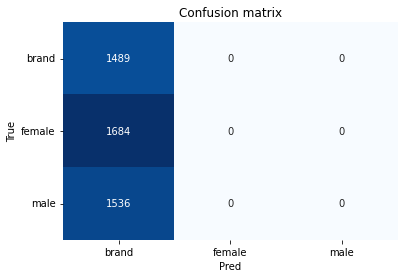

In [96]:
from sklearn import metrics
classes = np.unique(y_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",  round(accuracy,2))
print("Detail:")
print(metrics.classification_report(y_test, y_pred))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)


### 2.2 Random Forest

In [97]:
df2=df.copy()
df2 = df2.drop(['created','profile_yn','profile_yn:confidence','name'],axis = 1)##drop date created---8
df2 = df2.drop(['text','total_text','description','total_clean'],axis=1)
df2['link_color_id'] = df2['link_color_id'].astype(str)
df2['sidebar_color_id'] = df2['sidebar_color_id'].astype(str)
df2['fav_number'] = df2['fav_number'].astype(str)

In [98]:
X = df2.drop(['gender'], axis=1)
y = df2['gender']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25) 

In [99]:
#random forest
forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_train, y_train)
y_pred_random_forest = forest.predict(X_test)

Accuracy: 0.55
Detail:
              precision    recall  f1-score   support

       brand       0.64      0.62      0.63      1488
      female       0.55      0.57      0.56      1707
        male       0.46      0.46      0.46      1514

    accuracy                           0.55      4709
   macro avg       0.55      0.55      0.55      4709
weighted avg       0.55      0.55      0.55      4709



(array([0.5, 1.5, 2.5]), <a list of 3 Text major ticklabel objects>)

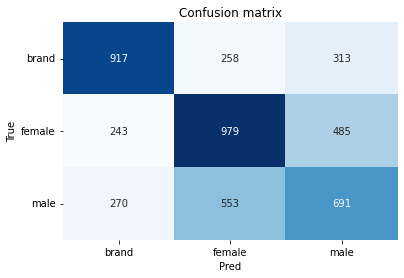

In [100]:
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, y_pred_random_forest)
print("Accuracy:",  round(accuracy,2))
print("Detail:")
print(metrics.classification_report(y_test, y_pred_random_forest))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_random_forest)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)


In [101]:
# feature_importances_  
feat_labels = X_train.columns

importances = forest.feature_importances_
print("importance：",importances)

#descending order
x_columns = X_train.columns
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

importance： [0.00105652 0.07662765 0.30596204 0.00961049 0.28336352 0.05439864
 0.11562523 0.15335591]
 1) fav_number                     0.305962
 2) tweet_count                    0.283364
 3) sentiment                      0.153356
 4) link_color_id                  0.115625
 5) gender:confidence              0.076628
 6) sidebar_color_id               0.054399
 7) retweet_count                  0.009610
 8) _trusted_judgments             0.001057


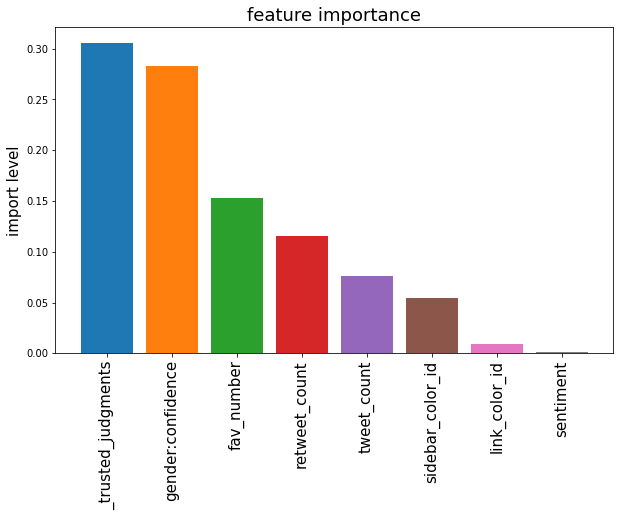

In [102]:
# Visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.title("feature importance",fontsize = 18)
plt.ylabel("import level",fontsize = 15)
for i in range(x_columns.shape[0]):
    plt.bar(i,importances[indices[i]],align='center')
    plt.xticks(np.arange(x_columns.shape[0]),x_columns,rotation=90,fontsize=15)
plt.show()

## 3. NLP Models

In [103]:
#train test split
X, y = df.total_clean, df.gender
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3) 
X_train[:10]

8054     matter dna ancient child offer clue people set...
2494     writer performer funny smart story page stage ...
17337           keep calm breath acrilex http co f kcutuje
6406     dnt judge look tush rugged living life regret ...
19862    clothed strength dignity laugh without fear fu...
9958     continuous price update fox chase bancorp fxcb...
5643     two iq mark short philosopher king bacon kill ...
1172     psychic reader healer pastlives health fitness...
10254    ediscovery recruitment consultant computer ner...
8219                            horrorweek government help
Name: total_clean, dtype: object

### 3.1 Feature Extraction

In [104]:
#countvectorizer
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')
feature1 = cv.fit_transform(X_train)
print(feature1.shape)
feature1
#print(feature.todense())

(13185, 7738)


<13185x7738 sparse matrix of type '<class 'numpy.int64'>'
	with 198651 stored elements in Compressed Sparse Row format>

In [105]:
#Tf-Idf
from sklearn.feature_extraction.text import TfidfVectorizer
tv = TfidfVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')
feature2 = tv.fit_transform(X_train)
print(feature2.shape)
#print(feature)
feature2

(13185, 7738)


<13185x7738 sparse matrix of type '<class 'numpy.float64'>'
	with 198651 stored elements in Compressed Sparse Row format>

### 3.2 CountVector+LogReg

In [106]:
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn.pipeline import Pipeline

In [107]:
classifier = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=1000))
model = Pipeline([('cv', cv),('classifier', classifier),])
model.fit(X_train,y_train)
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

In [108]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy
accuracy = metrics.accuracy_score(y_test, predicted)
print("Accuracy:",  round(accuracy,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    

Accuracy: 0.6
Detail:
              precision    recall  f1-score   support

       brand       0.74      0.66      0.70      1842
      female       0.57      0.62      0.59      2013
        male       0.50      0.50      0.50      1796

    accuracy                           0.60      5651
   macro avg       0.60      0.59      0.60      5651
weighted avg       0.60      0.60      0.60      5651



(array([0.5, 1.5, 2.5]), <a list of 3 Text major ticklabel objects>)

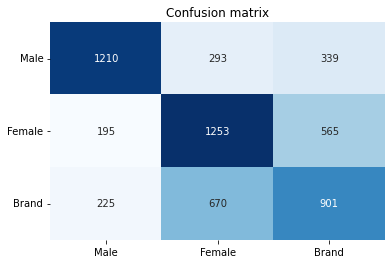

In [109]:
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues',
            cbar=False)
labels=['Male','Female','Brand']
ax.set(xticklabels=labels, yticklabels=labels, title="Confusion matrix") #xlabel="Pred", ylabel="True"
plt.yticks(rotation=0)



### 3.3 TF-IDF+SVC

In [110]:
from sklearn.svm import SVC, LinearSVC
classifier = classifier = OneVsRestClassifier(LinearSVC()) 

#from sklearn.pipeline import Pipeline
model = Pipeline([('tfidf', tv),('classifier', classifier),])
model.fit(X_train,y_train)
predicted = model.predict(X_test)

Accuracy: 0.59
Detail:
              precision    recall  f1-score   support

       brand       0.72      0.65      0.68      1842
      female       0.57      0.60      0.58      2013
        male       0.50      0.52      0.51      1796

    accuracy                           0.59      5651
   macro avg       0.60      0.59      0.59      5651
weighted avg       0.60      0.59      0.59      5651



(array([0.5, 1.5, 2.5]), <a list of 3 Text major ticklabel objects>)

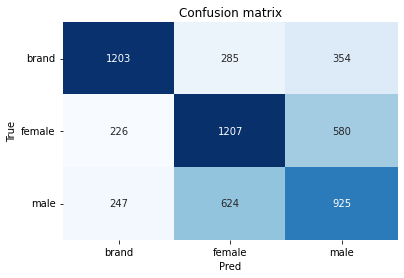

In [111]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy
accuracy = metrics.accuracy_score(y_test, predicted)
print("Accuracy:",  round(accuracy,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)



### 3.4 TF-IDF+LogReg

In [112]:
classifier = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=1000))
model = Pipeline([('tfidf', tv),('classifier', classifier),])
model.fit(X_train,y_train)
predicted = model.predict(X_test)

Accuracy: 0.61
Detail:
              precision    recall  f1-score   support

       brand       0.74      0.68      0.71      1842
      female       0.58      0.64      0.61      2013
        male       0.53      0.51      0.52      1796

    accuracy                           0.61      5651
   macro avg       0.62      0.61      0.61      5651
weighted avg       0.62      0.61      0.61      5651



(array([0.5, 1.5, 2.5]), <a list of 3 Text major ticklabel objects>)

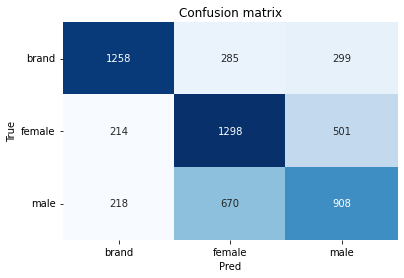

In [113]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy
accuracy = metrics.accuracy_score(y_test, predicted)
print("Accuracy:",  round(accuracy,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)


### 3.4 CounterVector + Random Forest

In [114]:
from sklearn.ensemble import RandomForestClassifier
classifier = OneVsRestClassifier(RandomForestClassifier())
model = Pipeline([('cv', cv),('classifier', classifier),])
model.fit(X_train,y_train)
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

In [115]:
accuracy = metrics.accuracy_score(y_test, predicted)
print(accuracy)

0.6046717395151301


In [123]:
## for explainer
from lime import lime_text
## select observation
i = 344
txt_instance = X_train.iloc[i]
## check true value and predicted value
print("True:", list(y_test)[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=
             np.unique(y_train))
explained = explainer.explain_instance(txt_instance, 
             model.predict_proba, num_features=3)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

True: brand --> Pred: brand | Prob: 0.79


## 4. LDA Analysis
The following is example of LDA Analysis for all genders - and we can apply this for female, male, and brand separately if needed and the procedures are simialr

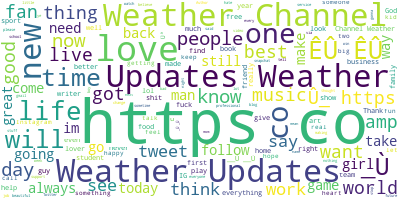

In [126]:
long_string = ','.join(list(df['total_text'].values))

from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=12, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [128]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

In [129]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 
                   'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come', 'co', 'http', 'https','eu', 'im'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [130]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)         
data = df_pca.total_text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])


[['sing', 'my', 'own', 'rhythm', 'robbie', 'responds', 'to', 'critics', 'after', 'win', 'against', 'eddie', 'edwards', 'in', 'the', 'https', 'co', 'nsybbmvjkz']]


In [131]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [132]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.033*"love" + 0.015*"life" + 0.012*"people" + 0.012*"look" + '
  '0.008*"friend" + 0.008*"much" + 0.007*"live" + 0.007*"always" + '
  '0.007*"family" + 0.007*"really"'),
 (1,
  '0.015*"follow" + 0.013*"work" + 0.010*"book" + 0.010*"new" + 0.009*"music" '
  '+ 0.008*"play" + 0.007*"tweet" + 0.007*"help" + 0.006*"start" + '
  '0.006*"account"'),
 (2,
  '0.026*"last" + 0.017*"time" + 0.014*"day" + 0.014*"still" + 0.009*"let" + '
  '0.009*"never" + 0.008*"well" + 0.008*"find" + 0.007*"home" + 0.007*"year"')]


In [133]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,3), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.592,"follow, work, book, new, music, play, tweet, h...","[sing, my, own, rhythm, robbie, responds, to, ..."
1,1,0.0,0.630,"love, life, people, look, friend, much, live, ...","[im, the, author, of, novels, filled, with, fa..."
2,2,0.0,0.519,"love, life, people, look, friend, much, live, ...","[louis, whining, and, squealing, and, all, abs..."
3,3,0.0,0.486,"love, life, people, look, friend, much, live, ...","[mobile, guy, ers, shazam, google, kleiner, pe..."
4,4,0.0,0.527,"love, life, people, look, friend, much, live, ...","[ricky, wilson, the, best, frontman, kaiser, c..."
5,5,0.0,0.492,"love, life, people, look, friend, much, live, ...","[you, dont, know, me, ive, seen, people, on, t..."
6,6,1.0,0.959,"follow, work, book, new, music, play, tweet, h...","[global, marketplace, for, images, videos, and..."
7,7,1.0,0.589,"follow, work, book, new, music, play, tweet, h...","[the, secret, of, getting, ahead, is, getting,..."
8,8,0.0,0.622,"love, life, people, look, friend, much, live, ...","[pll, fan, crazy, about, mcd, ramen, is, bae, ..."
9,9,2.0,0.549,"last, time, day, still, let, never, well, find...","[renaissance, art, historian, university, of, ..."


In [134]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.957,"love, life, people, look, friend, much, live, always, family, really","[just, regular, at, the, reject, table, engaged, endthestigma, kcco, love, my, twin, wwnd, ð_, a..."
1,1.0,0.967,"follow, work, book, new, music, play, tweet, help, start, account","[we, publish, music, industry, contact, directories, for, the, us, uk, canada, musician, music, ..."
2,2.0,0.947,"last, time, day, still, let, never, well, find, home, year","[shields, forensics, ya, fucka, ill, never, order, halloween, shit, from, china, ever, again, wo..."


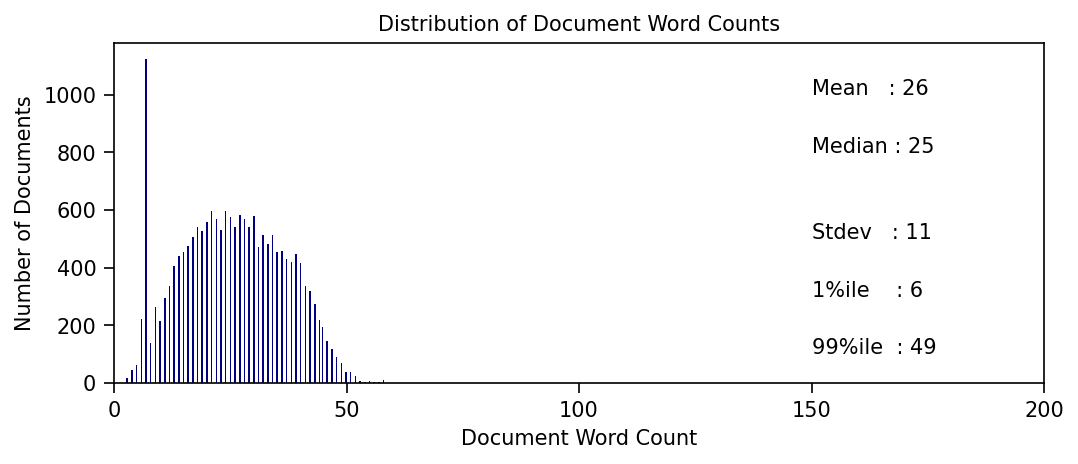

In [135]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(8,3), dpi=150)
plt.hist(doc_lens, bins = 500, color='navy')
plt.text(150, 1000, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(150,  800, "Median : " + str(round(np.median(doc_lens))))
plt.text(150,  500, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(150,  300, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(150,  100, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 200), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=5)
plt.xticks(np.linspace(0,200,5))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=10))
plt.show()

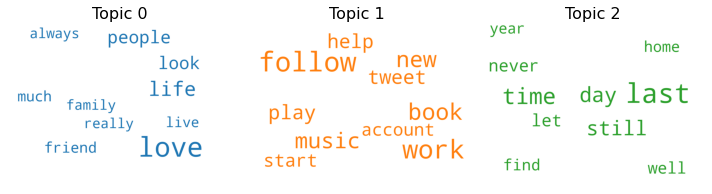

In [136]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [142]:
#pip install pyLDAvis

In [144]:
#import pyLDAvis.gensim
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.212300 -0.168994       1        1  35.941048
0     -0.262705 -0.087378       2        1  35.676689
2      0.050406  0.256371       3        1  28.382263, topic_info=        Term         Freq        Total Category  logprob  loglift
176     love  1832.000000  1832.000000  Default  30.0000  30.0000
295     last  1130.000000  1130.000000  Default  29.0000  29.0000
364     time   743.000000   743.000000  Default  28.0000  28.0000
326     life   859.000000   859.000000  Default  27.0000  27.0000
238   follow   818.000000   818.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
67    coffee   160.291534   160.941296   Topic3  -5.6187   1.2554
1132     set   178.530589   179.260322   Topic3  -5.5109   1.2553
1696    hair   192.007480   192.824144   Topic3  -5.4381   1.2552
1407   check   192.766520   193.787817   Topic3  -5.4342   1.2541
718     view   199.483146   200.749132   Topic3  -5.3999   1.2531

[132 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
188       1  0.996911  account
34        2  0.997563   always
142       3  0.996118      art
391       2  0.997260      ask
244       2  0.997860     back
...     ...       ...      ...
901       2  0.988467    write
201       1  0.002873   writer
201       2  0.996949   writer
201       3  0.002873   writer
42        3  0.996441     year

[120 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

### T-SNE Clustering

In [145]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 3
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 17302 samples in 0.023s...
[t-SNE] Computed neighbors for 17302 samples in 0.369s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17302
[t-SNE] Computed conditional probabilities for sample 2000 / 17302
[t-SNE] Computed conditional probabilities for sample 3000 / 17302
[t-SNE] Computed conditional probabilities for sample 4000 / 17302
[t-SNE] Computed conditional probabilities for sample 5000 / 17302
[t-SNE] Computed conditional probabilities for sample 6000 / 17302
[t-SNE] Computed conditional probabilities for sample 7000 / 17302
[t-SNE] Computed conditional probabilities for sample 8000 / 17302
[t-SNE] Computed conditional probabilities for sample 9000 / 17302
[t-SNE] Computed conditional probabilities for sample 10000 / 17302
[t-SNE] Computed conditional probabilities for sample 11000 / 17302
[t-SNE] Computed conditional probabilities for sample 12000 / 17302
[t-SNE] Computed conditional probabilities for sam

/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.392914


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:348: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max


[t-SNE] KL divergence after 1000 iterations: 0.866350
